In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import cv2
import pickle
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


Train directory exists: True
Test directory exists: True
Val directory exists: True

Current directory contents:
  app.ipynb
  chest_xray

Dataset Statistics:
Training set: Normal=1341, Pneumonia=3875
Test set: Normal=234, Pneumonia=390
Validation set: Normal=8, Pneumonia=8


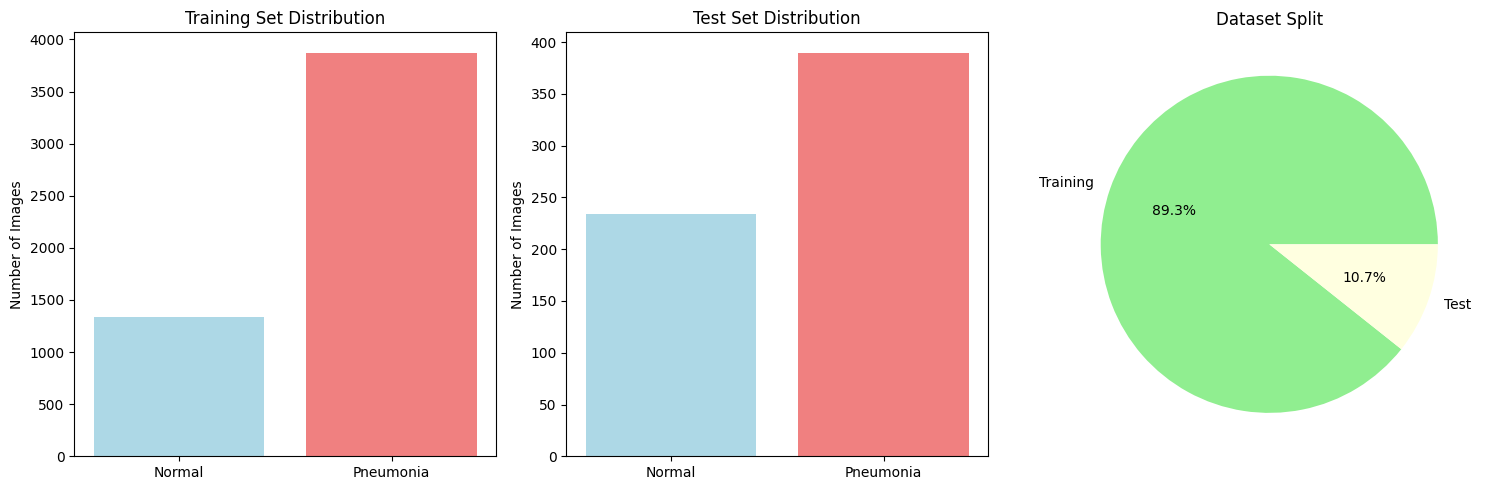

In [ ]:
dataset_path = "chest_xray"  
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
val_dir = os.path.join(dataset_path, 'val')

print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))
print("Val directory exists:", os.path.exists(val_dir))

print("\nCurrent directory contents:")
for item in os.listdir('.'):
    print(f"  {item}")
def count_images(directory):
    try:
        normal_path = os.path.join(directory, 'NORMAL')
        pneumonia_path = os.path.join(directory, 'PNEUMONIA')
        
        normal_count = len(os.listdir(normal_path)) if os.path.exists(normal_path) else 0
        pneumonia_count = len(os.listdir(pneumonia_path)) if os.path.exists(pneumonia_path) else 0
        return normal_count, pneumonia_count
    except Exception as e:
        print(f"Error counting images in {directory}: {e}")
        return 0, 0

train_normal, train_pneumonia = count_images(train_dir)
test_normal, test_pneumonia = count_images(test_dir)
val_normal, val_pneumonia = count_images(val_dir)

print(f"\nDataset Statistics:")
print(f"Training set: Normal={train_normal}, Pneumonia={train_pneumonia}")
print(f"Test set: Normal={test_normal}, Pneumonia={test_pneumonia}")
print(f"Validation set: Normal={val_normal}, Pneumonia={val_pneumonia}")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(['Normal', 'Pneumonia'], [train_normal, train_pneumonia], color=['lightblue', 'lightcoral'])
plt.title('Training Set Distribution')
plt.ylabel('Number of Images')

plt.subplot(1, 3, 2)
plt.bar(['Normal', 'Pneumonia'], [test_normal, test_pneumonia], color=['lightblue', 'lightcoral'])
plt.title('Test Set Distribution')
plt.ylabel('Number of Images')

plt.subplot(1, 3, 3)
plt.pie([train_normal + train_pneumonia, test_normal + test_pneumonia], 
        labels=['Training', 'Test'], 
        autopct='%1.1f%%', 
        colors=['lightgreen', 'lightyellow'])
plt.title('Dataset Split')

plt.tight_layout()
plt.show()

In [ ]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

val_test_datagen = ImageDataGenerator(rescale=1./255)
print("Creating data generators...")

try:
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        color_mode='grayscale',
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        color_mode='grayscale',
        shuffle=True
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False,
        color_mode='grayscale'
    )
    print("Class indices:", train_generator.class_indices)
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")
    print(f"Test samples: {test_generator.samples}")

except Exception as e:
    print(f"Error creating data generators: {e}")
    print("Please check your dataset path and directory structure.")

Creating data generators...
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 4173
Validation samples: 1043
Test samples: 624


Training samples:


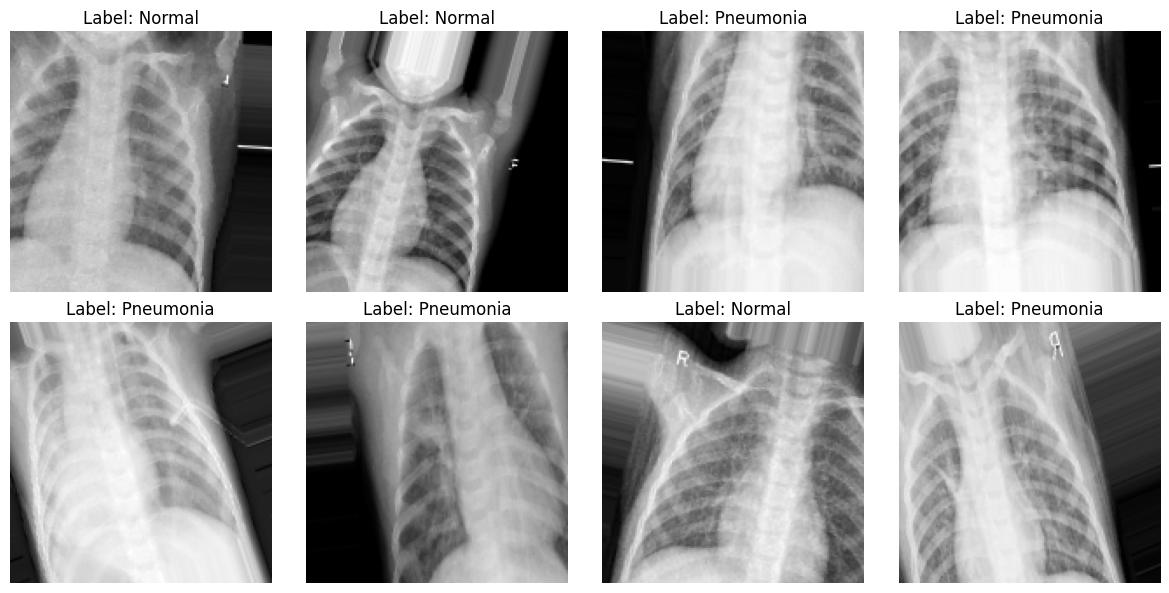

Validation samples:


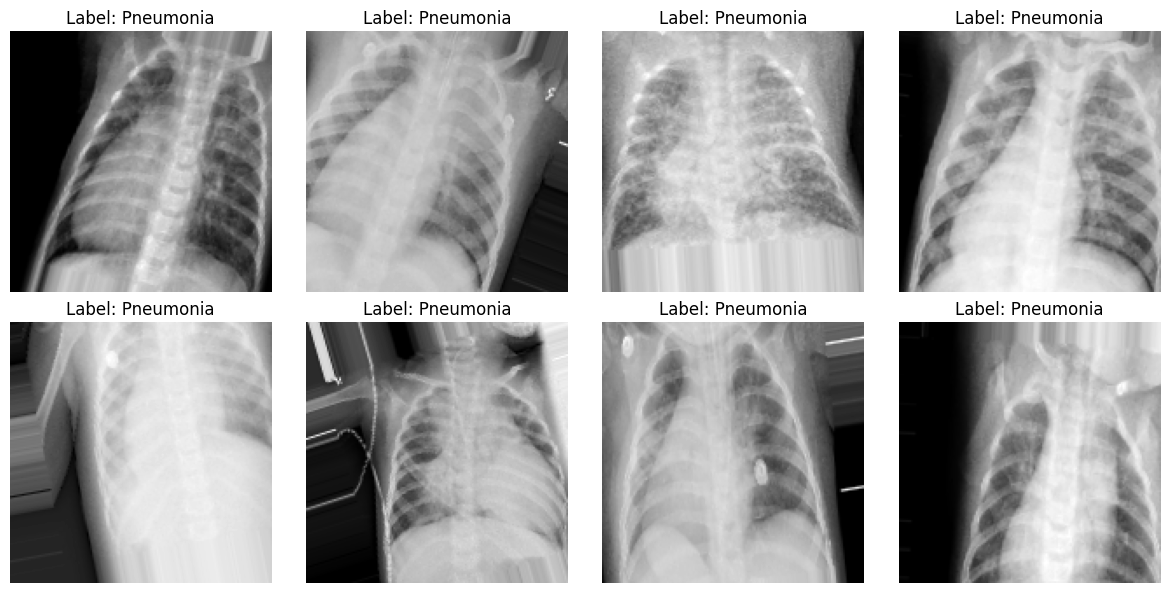

In [ ]:
def visualize_samples(generator, num_samples=8):
    """Visualize sample images from the generator"""
    try:
        images, labels = next(generator)
        class_names = ['Normal', 'Pneumonia']
        
        plt.figure(figsize=(12, 6))
        for i in range(min(num_samples, len(images))):
            plt.subplot(2, 4, i+1)
            plt.imshow(images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
            plt.title(f'Label: {class_names[int(labels[i])]}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing samples: {e}")

print("Training samples:")
visualize_samples(train_generator)

print("Validation samples:")
visualize_samples(validation_generator)

In [ ]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  
    ])
    
    return model
print("Building CNN model...")
model = create_cnn_model()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)
model.summary()

Building CNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,946,433 (26.50 MB)

 Trainable params: 6,944,449 (26.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)
train_steps = train_generator.samples // BATCH_SIZE
val_steps = validation_generator.samples // BATCH_SIZE

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

print("Starting model training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=30,  
    validation_data=validation_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Model training completed!")

Training steps per epoch: 130
Validation steps per epoch: 32
Starting model training...
Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7788 - loss: 0.5268 - precision: 0.8500 - recall: 0.8516 - val_accuracy: 0.7432 - val_loss: 6.6876 - val_precision: 0.7432 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.2347 - precision: 1.0000 - recall: 0.8750 - val_accuracy: 0.7368 - val_loss: 7.0265 - val_precision: 0.7368 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 107s 808ms/step - accuracy: 0.8678 - loss: 0.2936 - precision: 0.9135 - recall: 0.9071 - val_accuracy: 0.7451 - val_loss: 6.0348 - val_precision: 0.7451 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.9062 - loss: 0.2166 - precision: 1.0000 - recall: 0.8800 - val_accuracy: 0.6316 - val_loss: 8.3894 - val_precision: 0.6316 - val_recall: 

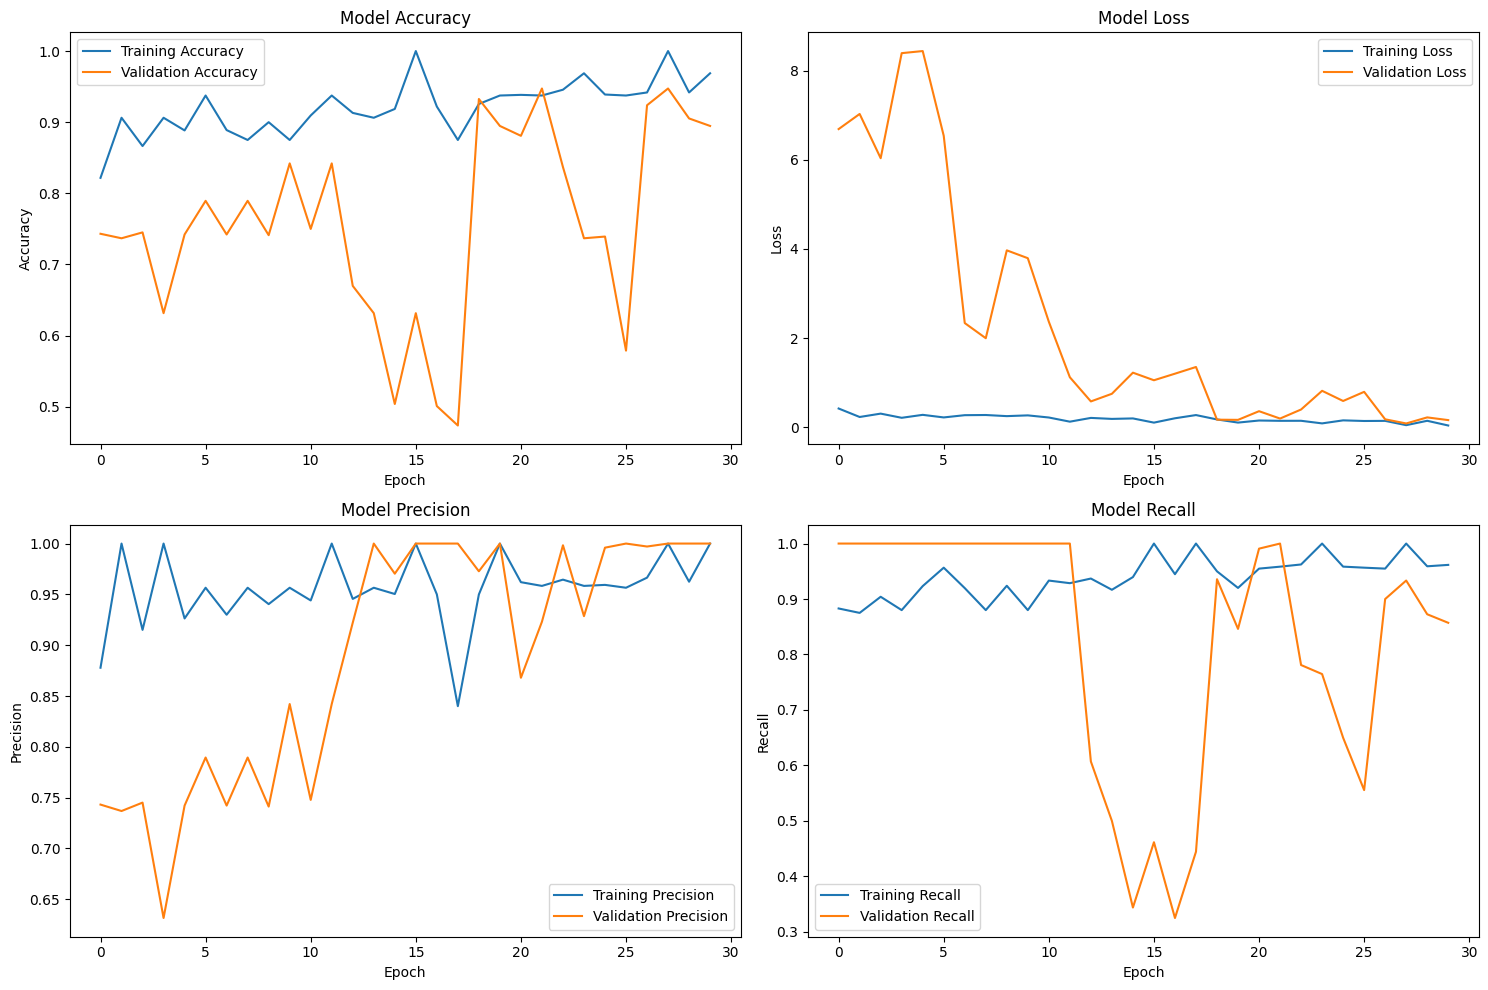

In [12]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
    
    
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
print("Evaluating model on test set...")

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"\nTest Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

test_predictions = model.predict(test_generator)
test_pred_classes = (test_predictions > 0.5).astype(int).flatten()
test_true_classes = test_generator.classes

print("\nClassification Report:")
print(classification_report(test_true_classes, test_pred_classes, 
                          target_names=['Normal', 'Pneumonia']))

Evaluating model on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 632ms/step - accuracy: 0.8984 - loss: 0.2855 - precision: 0.5755 - recall: 0.5449

Test Results:
Accuracy: 0.8510
Precision: 0.9459
Recall: 0.8077
F1-Score: 0.8714
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.74      0.92      0.82       234
   Pneumonia       0.95      0.81      0.87       390

    accuracy                           0.85       624
   macro avg       0.84      0.87      0.85       624
weighted avg       0.87      0.85      0.85       624



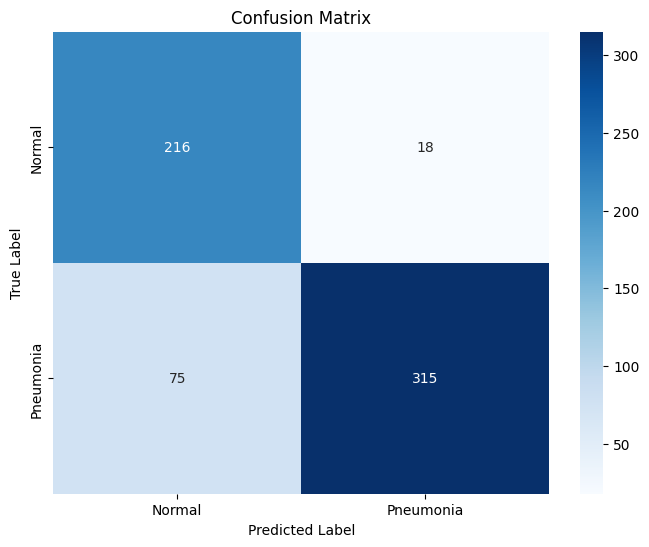


Detailed Metrics from Confusion Matrix:
True Positives (TP): 315
True Negatives (TN): 216
False Positives (FP): 18
False Negatives (FN): 75
Accuracy: 0.8510
Precision: 0.9459
Recall (Sensitivity): 0.8077
F1-Score: 0.8714
Specificity: 0.9231


In [14]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return cm

cm = plot_confusion_matrix(test_true_classes, test_pred_classes, ['Normal', 'Pneumonia'])
TN, FP, FN, TP = cm.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics from Confusion Matrix:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Specificity: {TN/(TN+FP) if (TN+FP) > 0 else 0:.4f}")

In [ ]:
print("Saving model and creating pickle file...")

model.save('pneumonia_detection_cnn.h5')
print("✓ Model saved as 'pneumonia_detection_cnn.h5'")

model_info = {
    'input_shape': (IMG_HEIGHT, IMG_WIDTH, 1),
    'class_names': ['Normal', 'Pneumonia'],
    'class_indices': train_generator.class_indices,
    'test_metrics': {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': 2 * (test_precision * test_recall) / (test_precision + test_recall)
    },
    'training_history': history.history,
    'model_summary': []
}

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
model_info['model_summary'] = stringlist

with open('pneumonia_model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("✓ Model information saved as 'pneumonia_model_info.pkl'")

model.save_weights('pneumonia_model_weights.weights.h5')
print("✓ Model weights saved as 'pneumonia_model_weights.weights.h5'")

print("\nVerifying created files:")
for filename in ['pneumonia_detection_cnn.h5', 'pneumonia_model_info.pkl', 'pneumonia_model_weights.weights.h5']:
    if os.path.exists(filename):
        file_size = os.path.getsize(filename) / (1024 * 1024)  # Size in MB
        print(f"✓ {filename} - {file_size:.2f} MB")
    else:
        print(f"✗ {filename} - NOT FOUND")

Saving model and creating pickle file...
✓ Model saved as 'pneumonia_detection_cnn.h5'


✓ Model information saved as 'pneumonia_model_info.pkl'
✓ Model weights saved as 'pneumonia_model_weights.weights.h5'

Verifying created files:
✓ pneumonia_detection_cnn.h5 - 79.59 MB
✓ pneumonia_model_info.pkl - 0.01 MB
✓ pneumonia_model_weights.weights.h5 - 79.56 MB


In [ ]:
print("Loading and verifying saved model...")

try:
    loaded_model = load_model('pneumonia_detection_cnn.h5')
    print("✓ Model loaded successfully from 'pneumonia_detection_cnn.h5'")
    with open('pneumonia_model_info.pkl', 'rb') as f:
        loaded_model_info = pickle.load(f)
    print("✓ Model info loaded successfully from 'pneumonia_model_info.pkl'")

    print(f"Input shape: {loaded_model_info['input_shape']}")
    print(f"Class names: {loaded_model_info['class_names']}")
    print(f"Test accuracy: {loaded_model_info['test_metrics']['accuracy']:.4f}")

    test_loss, test_accuracy, test_precision, test_recall = loaded_model.evaluate(test_generator)
    print(f"✓ Loaded model test accuracy: {test_accuracy:.4f}")

except Exception as e:
    print(f"Error loading model: {e}")
    print("Trying alternative approach...")
    try:
        simple_model = create_cnn_model()
        simple_model.load_weights('pneumonia_model_weights.h5')
        simple_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        print("✓ Model weights loaded successfully")
        
        test_loss, test_accuracy, test_precision, test_recall = simple_model.evaluate(test_generator)
        print(f"✓ Loaded weights test accuracy: {test_accuracy:.4f}")
        
    except Exception as e2:
        print(f"Error loading weights: {e2}")

Loading and verifying saved model...


✓ Model loaded successfully from 'pneumonia_detection_cnn.h5'
✓ Model info loaded successfully from 'pneumonia_model_info.pkl'
Input shape: (150, 150, 1)
Class names: ['Normal', 'Pneumonia']
Test accuracy: 0.8510
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.8984 - loss: 0.2855 - precision_1: 0.5755 - recall_1: 0.5449
✓ Loaded model test accuracy: 0.8510


Testing prediction function...


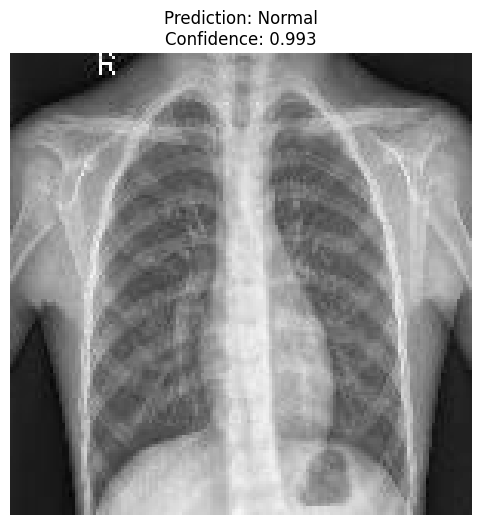

True class: Normal, Predicted: Normal, Confidence: 0.993


In [18]:


def predict_single_image(model, image_path, img_height=150, img_width=150):
    """
    Predict whether an image shows pneumonia or not
    """
    try:
        img = Image.open(image_path).convert('L')  
        img = img.resize((img_width, img_height))
        img_array = np.array(img) / 255.0
        img_array = img_array.reshape(1, img_height, img_width, 1)
        
        prediction = model.predict(img_array, verbose=0)[0][0]
        class_name = 'Pneumonia' if prediction > 0.5 else 'Normal'
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap='gray')
        plt.title(f'Prediction: {class_name}\nConfidence: {confidence:.3f}')
        plt.axis('off')
        plt.show()
        
        return class_name, confidence
        
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, None

print("Testing prediction function...")
try:
    test_images, test_labels = next(test_generator)
    sample_image = test_images[0]
    sample_label = test_labels[0]
    sample_img_array = (sample_image * 255).astype(np.uint8)
    sample_img = Image.fromarray(sample_img_array.reshape(IMG_HEIGHT, IMG_WIDTH))
    sample_img.save('sample_test_image.jpg')
    
    class_name, confidence = predict_single_image(loaded_model, 'sample_test_image.jpg')
    true_class = 'Pneumonia' if sample_label > 0.5 else 'Normal'
    print(f"True class: {true_class}, Predicted: {class_name}, Confidence: {confidence:.3f}")
    if os.path.exists('sample_test_image.jpg'):
        os.remove('sample_test_image.jpg')
        
except Exception as e:
    print(f"Error testing prediction function: {e}")

In [19]:
print("\n" + "="*50)
print("PNEUMONIA DETECTION MODEL - TRAINING COMPLETE")
print("="*50)

print(f"\nModel Performance Summary:")
print(f"• Test Accuracy: {test_accuracy:.4f}")
print(f"• Test Precision: {test_precision:.4f}")
print(f"• Test Recall: {test_recall:.4f}")
print(f"• Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

print(f"\nFiles Created:")
print(f"• pneumonia_detection_cnn.h5 - Complete trained model")
print(f"• pneumonia_model_info.pkl - Model information and metrics")
print(f"• pneumonia_model_weights.h5 - Model weights")

print(f"\nDataset Statistics:")
print(f"• Training samples: {train_generator.samples}")
print(f"• Validation samples: {validation_generator.samples}")
print(f"• Test samples: {test_generator.samples}")
print(f"• Classes: {list(train_generator.class_indices.keys())}")

print(f"\nModel can be loaded using:")
print("from tensorflow.keras.models import load_model")
print("model = load_model('pneumonia_detection_cnn.h5')")


PNEUMONIA DETECTION MODEL - TRAINING COMPLETE

Model Performance Summary:
• Test Accuracy: 0.8510
• Test Precision: 0.9459
• Test Recall: 0.8077
• Test F1-Score: 0.8714

Files Created:
• pneumonia_detection_cnn.h5 - Complete trained model
• pneumonia_model_info.pkl - Model information and metrics
• pneumonia_model_weights.h5 - Model weights

Dataset Statistics:
• Training samples: 4173
• Validation samples: 1043
• Test samples: 624
• Classes: ['NORMAL', 'PNEUMONIA']

Model can be loaded using:
from tensorflow.keras.models import load_model
model = load_model('pneumonia_detection_cnn.h5')
